We see GP-MAB algorithms in an optimal bidding problem. We compare GP-Thompson Sampling with a TS with Gaussian distributions.

Why combining GP with MABs? Standard MAB algortithms perform poorly in many complex real-world problems where the arms space is large. GP-MAB algorithms are instead suitable for real-world problems in which the arms space is large and the arms are correlated.

We consider a time horizon of 60 days, a fixed daily budget at each day and 20 possible bids. We want to maximize the number of clicks (since we have a fixed daily budget, the optimal bid is not necessarely the one with the higher value; however, close value of bids correspond to close values of number of clicks, therefore we can exploit this correlation while learning).

We build a Bidding Environment Class. The environment returns a stochastic reward (i.e. number of clicks) depending on the pulled arm (choosen bid). We have to specify a function that maps a bid value to the corresponding expected number of clicks. The number of clicks is not deterministic, each value is associated with a Gaussian distribution.

In [1]:
import numpy as np

In [2]:
# function that maps bids to the corresponding number of bids
def fun(x):
  return 100 * (1.0 - np.exp(-4*x+3*x**3))

In [3]:
class BiddingEnvironment():
  # constructor takes an array of possible bids and the standard deviation of the reward function (for simplicity we assume the same std for all reward functions)
  def __init__(self, bids, sigma):
    self.bids = bids
    self.means = fun(bids)
    self.sigmas = np.ones(len(bids)) * sigma

  # function that, given the index of an arm (bid choosen by the learner), returns the reward (drawn from a normal distribution)
  def round(self, pulled_arm):
    return np.random.normal(self.means[pulled_arm], self.sigmas[pulled_arm])

We now pass to the Gaussian TS-Learner class. The GTS-Learner, at each round, updates the parameters of a normal distribution associated to the pulled arm.

In [4]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [5]:
class GTS_Learner(Learner):
  # contructor takes as input the number of arms, intializes the estimated means to 0 and the sigmas to an eye value
  def __init__(self, n_arms):
    super().__init__(n_arms)
    self.means = np.zeros(n_arms)
    self.sigmas = np.ones(n_arms) * 1e3  # 1e3 refers to the fact that there is an initial high probability to be pulled for each arm, since we have no prior information

  # function that draws a sample from each distribution and returns the index of the sample with maximum value
  def pull_arm(self):
    idx = np.argmax(np.random.normal(self.means,self.sigmas))
    return idx

  # function that, given the pulled arm and the reward, updates the observtion and the estimation fo the parameters
  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)  # updates the array in which we store the values of the collected rewards
    self.means[pulled_arm] = np.mean(self.rewards_per_arm[pulled_arm])
    n_samples = len(self.rewards_per_arm[pulled_arm])
    if n_samples > 1:
      self.sigmas[pulled_arm] = np.std(self.rewards_per_arm[pulled_arm])/n_samples

    # if we collected at least two samples, we can update the standard deviation

We now consider the GPTS-Learner Class. At each round, the GPTS-Learner has to fit a GP with the chosen bids as inputs and the observed number of clicks as targets. It uses the GP to predict the means and variances of the distributions associated to each arm (bid value). Since the estimations of the means are correlated, the learning will be faster than the one of the GTS algirthm, that estimates the distributions separately.

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [7]:
class GPTS_Learner(Learner):
  # constructor takes as input the number arms (bids), intializes to 0 their means and to an aye their standard deviation; we also need to store the arm that we pull at each round to fot the GPs
  def __init__(self, n_arms, arms):
    super().__init__(n_arms)
    self.arms = arms
    self.means = np.zeros(self.n_arms)
    self.sigmas = np.ones(self.n_arms) * 10
    self.pulled_arms = []
    # we initialize the parameters of the kernel and the GP
    alpha = 10  # standard deviation of the noise
    kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3)) # kernel (squared exponential) with the range of the parameters
    self.gp = GaussianProcessRegressor(kernel = kernel, alpha = alpha**2, n_restarts_optimizer = 10)  # Gaussian Process regressor, with target normalization and optimizer restarts (normalize_y = True)

  # we also need to update the value of the least pulled arm
  def update_observations(self, arm_idx, reward):
    super().update_observations(arm_idx, reward)
    self.pulled_arms.append(self.arms[arm_idx])

  # update the GP estimations and consequently the means and sigmas of each arm
  def update_model(self):
    # trining inputs and targets
    x = np.atleast_2d(self.pulled_arms).T
    y = self.collected_rewards
    # fit the GP
    self.gp.fit(x,y)
    # update values of means and sigmas with the new predictions
    self.means, self.sigmas = self.gp.predict(np.atleast_2d(self.arms).T, return_std = True)
    self.sigmas = np.maximum(self.sigmas, 1e-2)  # force sigmas > 0

  # functions that calls the functions implemented above
  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)
    self.update_model()

  # function in which the learner chooses the arm to pull at each round
  def pull_arm(self):
    # returns index of the maximum value drawn from the arm normal distribution
    sampled_values = np.random.normal(self.means, self.sigmas)
    return np.argmax(sampled_values)

Now we compare the two learners.

In [8]:
import matplotlib.pyplot as plt

Output streaming troncato alle ultime 5000 righe.
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-package

<function matplotlib.pyplot.show(close=None, block=None)>

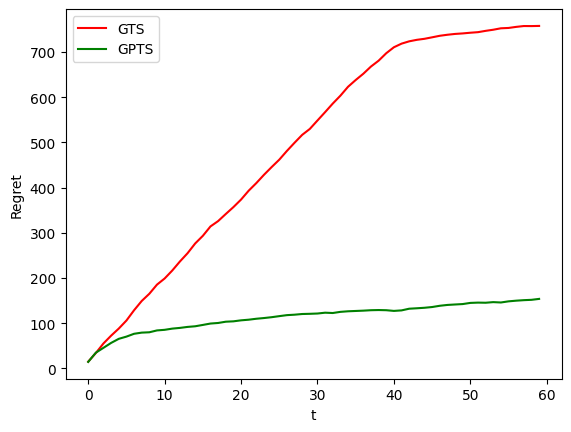

In [9]:
n_arms = 20
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 10
# time horizon
T = 60
n_experiments = 100
# initialize list for the collected rewards of the experiments
gts_rewards_per_experiment = []
gpts_rewards_per_experiment = []

for e in range(0,n_experiments):  # cycle on experiments
  print(e)
  env = BiddingEnvironment(bids = bids, sigma = sigma)
  gts_learner = GTS_Learner(n_arms = n_arms)
  gpts_learner = GPTS_Learner(n_arms = n_arms, arms = bids)
  for t in range(0,T):  # cycle on time horizon
    # Gaussian Thompson Sampling
    pulled_arm = gts_learner.pull_arm()
    reward = env.round(pulled_arm)
    gts_learner.update(pulled_arm, reward)

    # GP Thompson Sampling
    pulled_arm = gpts_learner.pull_arm()
    reward = env.round(pulled_arm)
    gpts_learner.update(pulled_arm, reward)

  gts_rewards_per_experiment.append(gts_learner.collected_rewards)
  gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)

opt = np.max(env.means)
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - gts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(opt - gpts_rewards_per_experiment, axis = 0)), 'g')
plt.legend(["GTS", "GPTS"])
plt.show

The regret of the GTS is much bigger than the one of GPTS. This happen because the GTS algorithm requires much more exploration to have accurate estimations of the rewards' distributions.